In [10]:
###import all required Modules###
import quandl
quandl.ApiConfig.api_key = "9vPrGucrCNLePvVC211H"
import yfinance as yf
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
%matplotlib notebook

In [11]:
###retrive data for SNP 500 to use as market proxy###
snpdata = yf.Ticker('^GSPC').history(period='1d', start='2017-09-29', end='2022-09-30')
snpdata = snpdata[['Close']]
#replacing the date with an numbered index
snpdata.reset_index(inplace=True)
#making the date soley the day
snpdata['Date'] = snpdata['Date'].dt.date
#print(snpdata.head())

In [12]:
#creating column for percentage change and dropping first row
snpdata['percentage_change'] = snpdata['Close'].pct_change()
snpdata = snpdata.drop(snpdata.index[0])
sigma_m = np.sqrt(snpdata['percentage_change'].var()*252)
#print(annual_snp_std)

In [13]:
#function that makes sure ticker exists
def ticker_exist(ticker):
    try:
        stock_info = yf.Ticker(ticker)
        return stock_info.info['sector'] is not None
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return False

In [16]:
#Ask for stocks that user wishes to put in their portfolio
user_input = input("which stocks do you wish to be in your portfolio?(seperate them by coma)")
tickers = [ticker.strip().upper() for ticker in user_input.split(',')]
#AAPL,INTC,GOGL,MRK,UNH,AMZN,HD,MCD,NKE,JPM,BAC,WFC,BA,MMM,T,VZ,DIS,PG,KO,NEE,AMT,ECL,XOM 

which stocks do you wish to be in your portfolio?(seperate them by coma)AAPL,INTC,GOGL,MRK,UNH


In [17]:
#puts real tickers in a list
real_tickers = []
for ticker in tickers:
    if ticker_exist(ticker):
        real_tickers.append(ticker)
    else:
        print(f"''{ticker}' is not a valid ticker and will be ignored.")

In [18]:
###retrive data for real_tickers###

stockprices = quandl.get_table('SHARADAR/SEP', ticker=[real_tickers], date={'gte':'2017-09-29', 'lte':'2022-09-29'},paginate=True)
#makes the data show in chronological order
stockprices = stockprices.iloc[::-1].reset_index(drop=True)
#makes the stockprices become a readable panel of data 
stock_price_panel = stockprices.pivot(index='date', columns='ticker', values='close')
#print(stock_price_panel)

In [19]:
#makes stock_price_panel show percentage change in prices and drop first row
stock_price_panel_percent = stock_price_panel.pct_change().drop(stock_price_panel.index[0])
#print(stock_price_panel_percent)

In [20]:
###Calculate asset beta for stocks in real_ticker###

market_returns = snpdata['percentage_change']
var_market = np.var(market_returns)

betas = {}

for ticker in tickers:
    stock_returns = stock_price_panel_percent[ticker]
    # Calculate covariance between stock and market returns
    cov_matrix = np.cov(stock_returns, market_returns)
    cov_stock_market = cov_matrix[0, 1]
    
    # Calculate beta
    beta = cov_stock_market / var_market
    betas[ticker] = beta

In [21]:
stock_data_df = pd.Series(betas).to_frame(name='Beta')
#print(stock_data_df)

In [22]:
### Get other components requiered for CAPM model ###
#First Retrieve E(Rm)
annualized_market_return = (1 + market_returns.mean())**252 - 1

In [23]:
#risk free rate rf as of 8th october 2023
rf = 0.0513

In [24]:
#Calculate Market Premium 

market_premium = annualized_market_return - rf

In [25]:
#Calculate expected return for ticker
stock_data_df['Expected_Return'] = rf + stock_data_df['Beta'] * market_premium
stock_data_df.head()

,Beta,Expected_Return
AAPL,1.213326,0.111684
INTC,1.205504,0.111295
GOGL,1.173975,0.109726
MRK,0.575337,0.079933
UNH,0.951470,0.098652


In [26]:
#calculate real return for stocks
ticker_real_return = (1 + stock_price_panel_percent.mean())**252 - 1 #approximately 252 trading days a year
type(ticker_real_return)
stock_data_df['Real_Return'] = ticker_real_return
#stock_data_df.head()

<IPython.core.display.Javascript object>


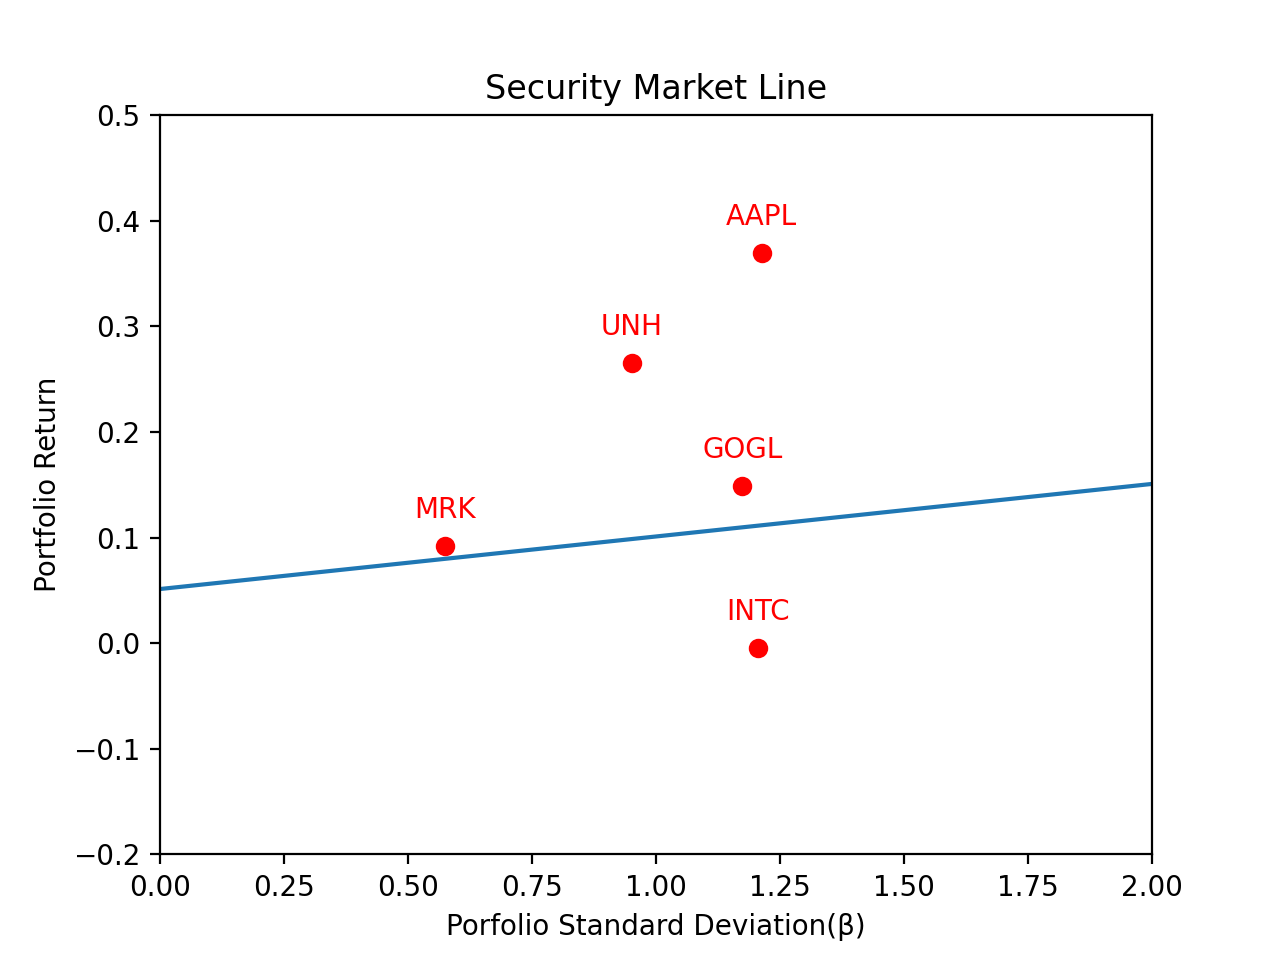

In [27]:
#Plot SML
def SML(x):
    return market_premium * x + rf
x = np.linspace(0, 2, 100)
y = SML(x)
plt.plot(x, y)

plt.xlabel("Porfolio Standard Deviation(β)")
plt.ylabel("Portfolio Return")
plt.title("Security Market Line")
plt.xlim(0,2)
plt.ylim(-0.2,0.5)
plt.scatter(stock_data_df['Beta'], stock_data_df['Real_Return'], color='red')
for stock, row in stock_data_df.iterrows():
    plt.annotate(stock, (row['Beta'], row['Real_Return']), textcoords="offset points", xytext=(0,10), ha='center', color='red')
plt.show()

In [28]:
###Remember stocks below the SML are overvalued according to CAPM and we want undervalued stocks in our portfolio###

In [29]:
undervalued_stocks = stock_data_df[stock_data_df['Real_Return'] > stock_data_df['Expected_Return']]

In [30]:
print(undervalued_stocks)

          Beta  Expected_Return  Real_Return
AAPL  1.213326         0.111684     0.369872
GOGL  1.173975         0.109726     0.149192
MRK   0.575337         0.079933     0.091861
UNH   0.951470         0.098652     0.265168


In [31]:
#Calculate Variance 

undervalued_stocks['Variance'] = 0.0
undervalued_stocks['Std_dev'] = 0.0

# Calculating and assigning the variance for the stocks listed in undervalued_stocks
for ticker in undervalued_stocks.index:
    undervalued_stocks.at[ticker, 'Variance'] = stock_price_panel_percent[ticker].var() * 252 # annualizing
    undervalued_stocks.at[ticker, 'Std_dev'] = np.sqrt(stock_price_panel_percent[ticker].var() * 252)

#undervalued_stocks.head()

/var/folders/50/376c773d5pjfp5chsw9rs5040000gn/T/ipykernel_14697/3930042411.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  undervalued_stocks['Variance'] = 0.0
/var/folders/50/376c773d5pjfp5chsw9rs5040000gn/T/ipykernel_14697/3930042411.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  undervalued_stocks['Std_dev'] = 0.0


In [32]:
#Create Covariance Matrix of stocks with the undervalued stocks
common_tickers = undervalued_stocks.index.intersection(stock_price_panel_percent.columns)
common_undervalued_stocks = undervalued_stocks.loc[common_tickers]
common_stock_price_panel_percent = stock_price_panel_percent[common_tickers]
cov_matrix = common_stock_price_panel_percent.cov()
#cov_matrix.head()


In [33]:
num_portfolios = 10000

In [34]:
expected_returns = undervalued_stocks['Expected_Return']

In [35]:
#undervalued_stocks.head()
#print(undervalued_stocks.columns)

In [36]:
# get the portfolio return and std deviation#     ###this section is fine###
def portfolio_annualised_performance(weights, expected_returns, cov_matrix):
    returns = np.sum(expected_returns*weights) 
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [37]:
#create random portfolio and store where it will plot 
def random_portfolios(num_portfolios, undervalued_stocks, cov_matrix, rf):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    #expected_returns = undervalued_stocks['Expected_Return']
    for i in range(num_portfolios):
        weights = np.random.random(len(undervalued_stocks))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, expected_returns, cov_matrix)
        results[0, i] = portfolio_std_dev
        results[1, i] = portfolio_return
        results[2, i] = (portfolio_return - rf) / portfolio_std_dev
    return results, weights_record

In [61]:
def display_simulated_ef_width_random(expected_returns, cov_matrix, num_portfolios, rf):
    results, weights = random_portfolios(num_portfolios, expected_returns,cov_matrix, rf)

    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0, max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index = undervalued_stocks.index, columns = ['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index = undervalued_stocks.index, columns=["allocation"])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T

    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio\n")
    print("Annualized Return:", round(rp,3))
    print("Annualized Volatility:", round(sdp,3))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,3))
    print("Annualised Volatility:", round(sdp_min,3))
    print("\n")
    print(min_vol_allocation)

    plt.figure(figsize=(10,7))
    plt.scatter(results[0,:], results[1,:], c=results[2,:], marker='o', s=10)
    plt.colorbar(label = 'Sharpe Ratio')
    plt.scatter(sdp,rp,marker='.', color ='r', s=50, label="Maximum Sharpe ratio")
    plt.scatter(sdp_min, rp_min, marker='.', color='g', s=50, label='minimum volatility')
    
    
    #Creating Capital Market Line
    
    x1, y1 = 0, rf
    x2, y2 = sdp, rp
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1
    
    
    def line_func(x):
        return m * x + b
    
    x_values = np.linspace(start=min(x1, x2)-0, stop=max(x1, x2)+0.3, num=400)
    y_values = line_func(x_values)
    plt.plot(x_values, y_values, label = 'Capital Market Line', color = 'red')
    
    #Labelling the standard deviation and expected return of each stock in undervalued_stocks
        
    
    for stock in undervalued_stocks.index:
        plt.plot(undervalued_stocks.loc[stock, 'Std_dev'], undervalued_stocks.loc[stock, 'Expected_Return'], marker='x', label=stock)
        
        
        
        
    plt.title("Simulated Portfolio Optimisation based on Efficient Frontier")
    plt.xlabel('annualised volatility(σ)')
    plt.ylabel("annualised returns")
    plt.xlim(0,0.4)
    plt.ylim(0.05,0.15)
    plt.grid(True)
    plt.legend(labelspacing=0.8)
    plt.show()


--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio

Annualized Return: 0.102
Annualized Volatility: 0.244


            AAPL  GOGL    MRK    UNH
allocation  45.9  7.11  18.36  28.63
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Minimum Volatility Portfolio Allocation

Annualised Return: 0.089
Annualised Volatility: 0.212


             AAPL  GOGL    MRK    UNH
allocation  17.52  0.79  63.26  18.43


<IPython.core.display.Javascript object>


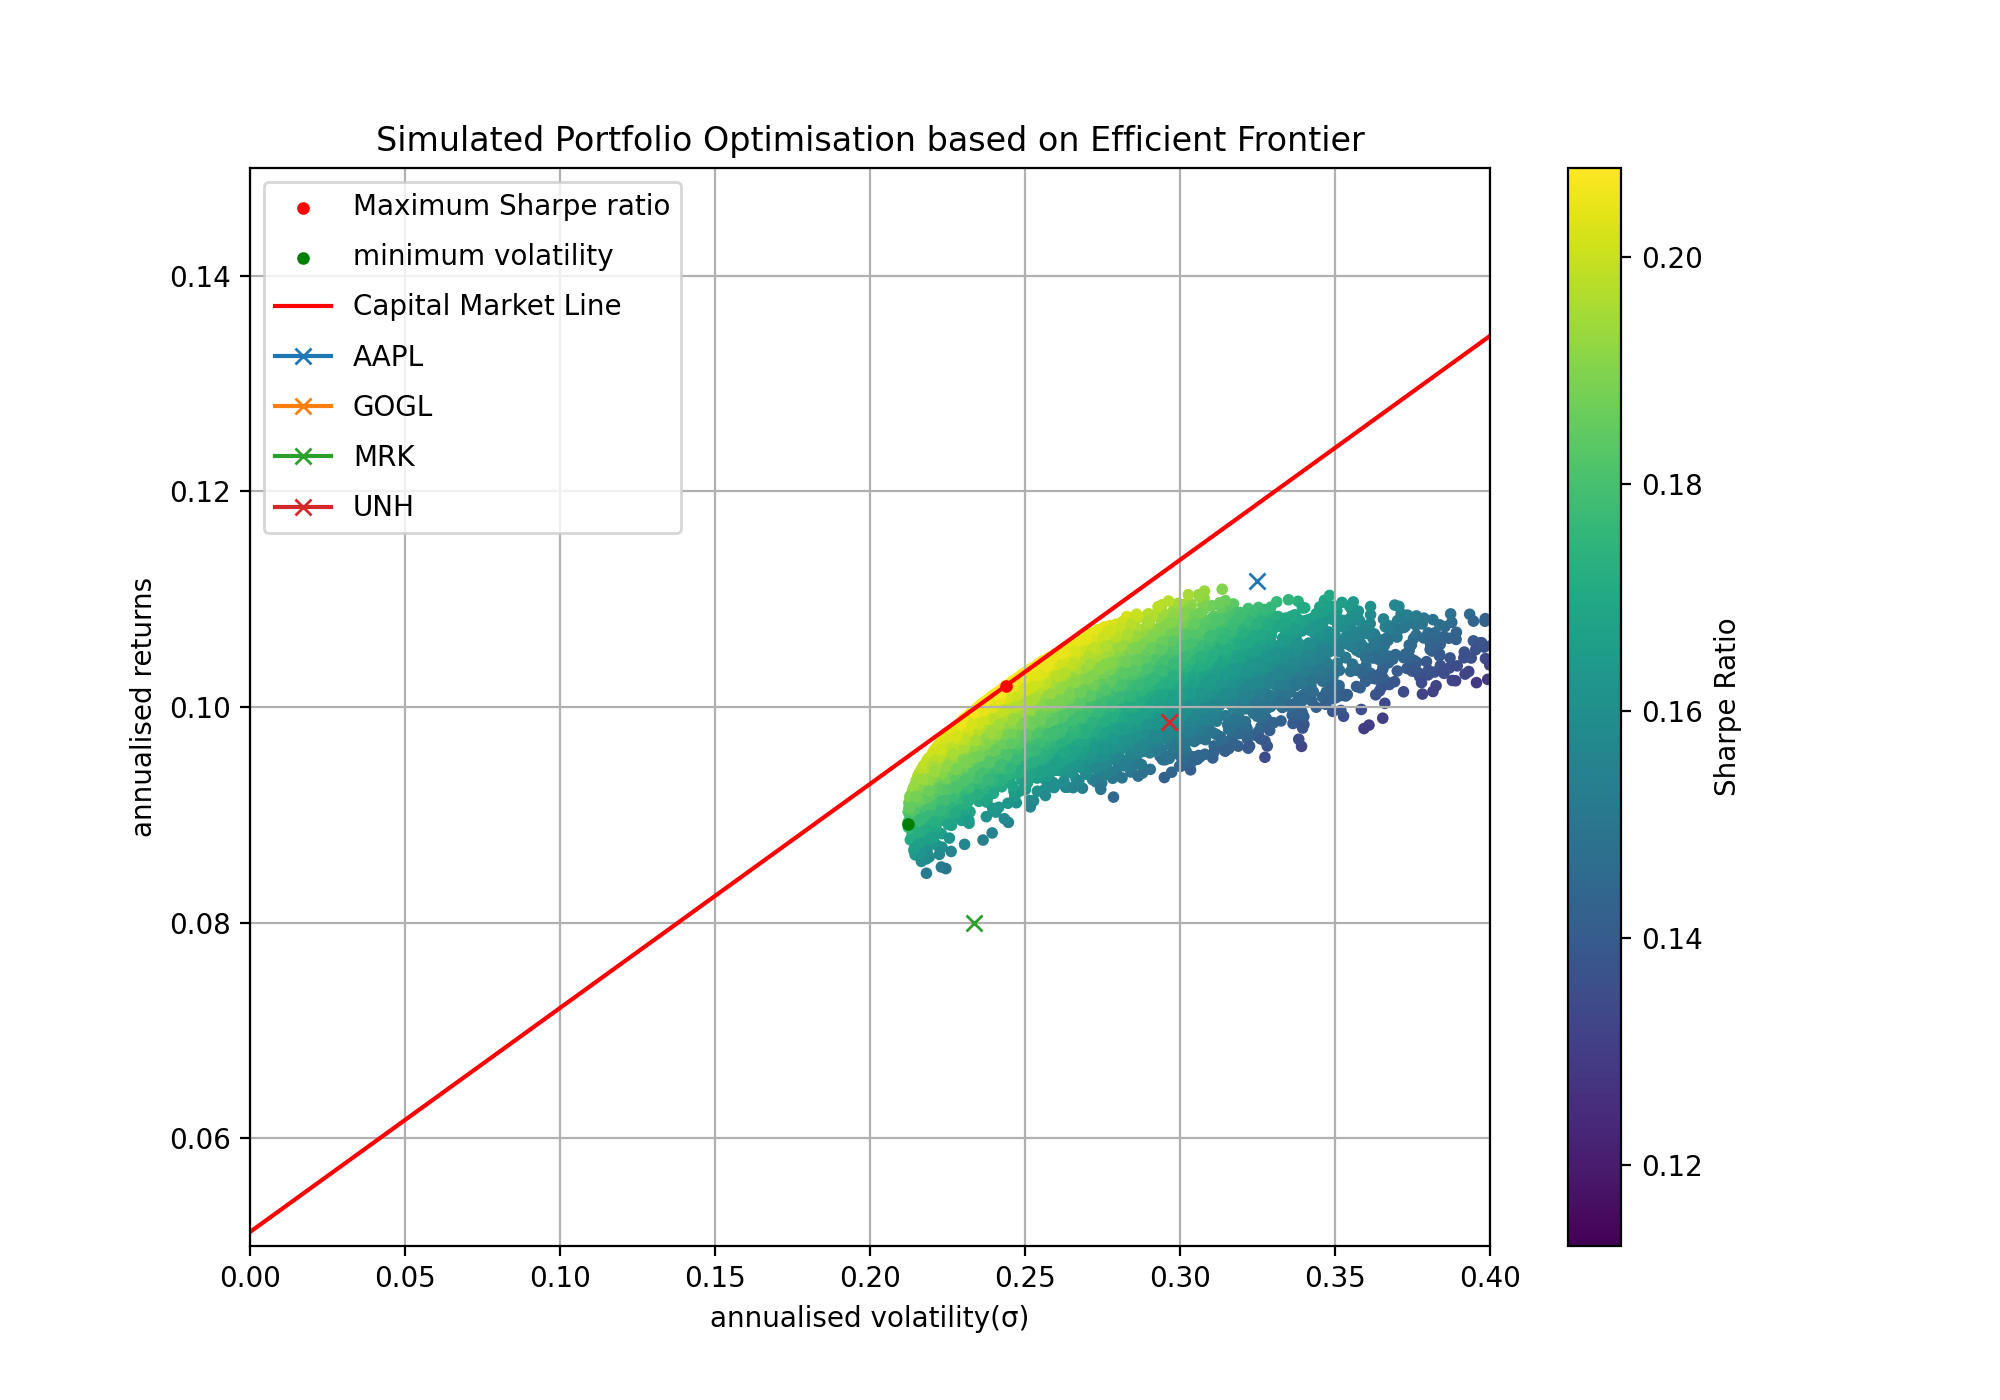

In [62]:
display_simulated_ef_width_random(expected_returns, cov_matrix, num_portfolios, rf)

In [110]:
###Investors optimal Portfolio###

#idea add a slider along the Capital Market line so the investor can guage the 
#level of risk and return that they want as utility curve for average consumer is impractical and in this case arbitrary

In [46]:
t=widgets.FloatSlider(value=0.5, min=0, max=1, step=0.01, description='t:')


In [38]:
def move_point_along_line(rf, sdp, rp, t):
    x = 0 + t * (sdp - 0)
    y = rf + t * (rp - rf)
    return (x, y)

In [47]:
def display_simulated_ef_width_random(expected_returns, cov_matrix, num_portfolios, rf):
    results, weights = random_portfolios(num_portfolios, expected_returns,cov_matrix, rf)

    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0, max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index = undervalued_stocks.index, columns = ['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index = undervalued_stocks.index, columns=["allocation"])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T

    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio\n")
    print("Annualized Return:", round(rp,3))
    print("Annualized Volatility:", round(sdp,3))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,3))
    print("Annualised Volatility:", round(sdp_min,3))
    print("\n")
    print(min_vol_allocation)

    plt.figure(figsize=(10,7))
    plt.scatter(results[0,:], results[1,:], c=results[2,:], marker='o', s=10)
    plt.colorbar(label = 'Sharpe Ratio')
    plt.scatter(sdp,rp,marker='.', color ='r', s=50, label="Maximum Sharpe ratio")
    plt.scatter(sdp_min, rp_min, marker='.', color='g', s=50, label='minimum volatility')
    
    
    #Creating Capital Market Line
    
    x1, y1 = 0, rf
    x2, y2 = sdp, rp
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1
    
    
    def line_func(x):
        return m * x + b
    
    x_values = np.linspace(start=min(x1, x2)-0, stop=max(x1, x2)+0.3, num=400)
    y_values = line_func(x_values)
    plt.plot(x_values, y_values, label = 'Capital Market Line', color = 'red')
    new_point = move_point_along_line(rf, sdp, rp, t)
    
    #Labelling the standard deviation and expected return of each stock in undervalued_stocks
        
    
    for stock in undervalued_stocks.index:
        plt.plot(undervalued_stocks.loc[stock, 'Std_dev'], undervalued_stocks.loc[stock, 'Expected_Return'], marker='x', label=stock)
        
        
        
        
    plt.title("Simulated Portfolio Optimisation based on Efficient Frontier")
    plt.xlabel('annualised volatility(σ)')
    plt.ylabel("annualised returns")
    plt.xlim(0,0.4)
    plt.ylim(0.05,0.15)
    plt.grid(True)
    plt.legend(labelspacing=0.8)
    plt.show()
    widgets.interactive(display_simulated_ef_width_random, t=widgets.FloatSlider(value=0.5, min=0, max=1, step=0.01, description='t:'))

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio

Annualized Return: 0.102
Annualized Volatility: 0.243


             AAPL  GOGL    MRK    UNH
allocation  44.36  8.14  18.48  29.02
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Minimum Volatility Portfolio Allocation

Annualised Return: 0.09
Annualised Volatility: 0.212


             AAPL  GOGL    MRK    UNH
allocation  18.78  3.05  60.82  17.35


<IPython.core.display.Javascript object>


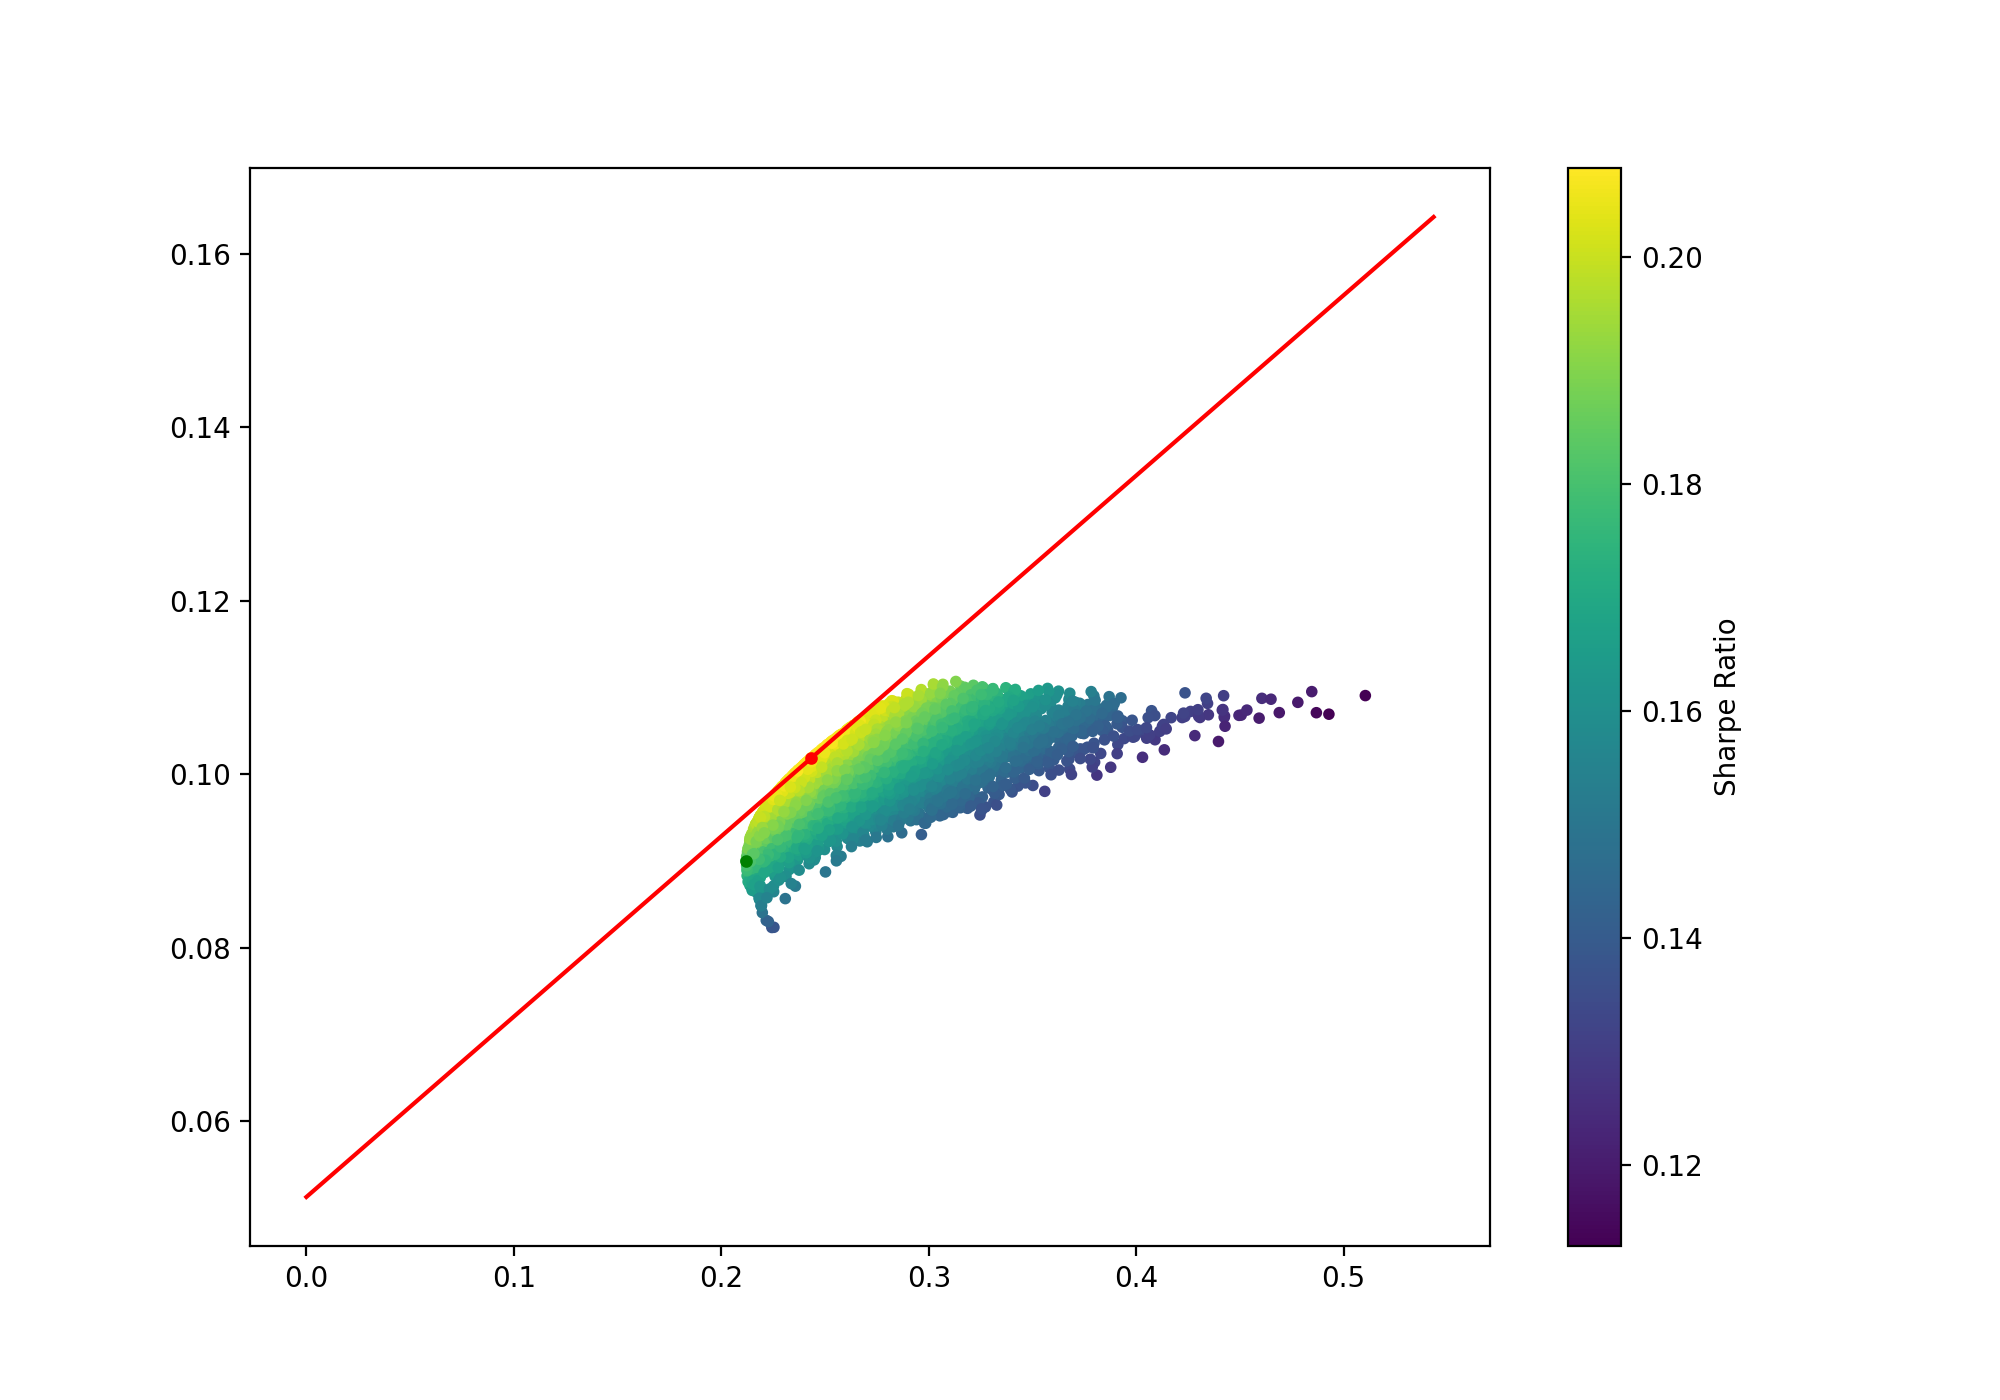

TypeError: unsupported operand type(s) for *: 'FloatSlider' and 'float'

In [48]:
display_simulated_ef_width_random(expected_returns, cov_matrix, num_portfolios, rf)